# Analyze price data

For an example, compare the price data on different exchanges

Analyze data quality

Check availability
* Public holidays
* weekends
* etc.

In [1]:
# General
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re

# File download
from tqdm.notebook import tqdm, trange

# Custom modules
from Tools import S3

# Hidden configurations
from mySecrets import config_file, AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_BUCKET


In [1]:
# Connect to AWS S3 storage
# s3 = S3()
# s3.connect(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

In [43]:
# Definition of relevant symbols
df_sym_sel = [
    # North America
    # ~ USA
    ['AAPL', 'USD', 'NasdaqGS'],

    # ~ Canada
    ['AAPL.NE', 'CAD', 'NEO'],

    # ~ Mexico
    ['AAPL.MX', 'MXN', 'Mexico'],

    # Latin America
    # ~ Argentina
    ['AAPL.BA', 'ARS', 'Buenos Aires'],
    # ['AAPLD.BA', 'USD', 'Buenos Aires'], this one causes trouble

    # ~ Chile
    ['AAPL.SN', 'USD', 'Santiago'],
    ['AAPLLCL.SN', 'CLP', 'Santiago'],

    # ~ Brazil
    ['AAPL34.SA', 'BRL', 'Sao Paulo'],

    # European Exchanges
    # ~ Germany
    ['APC.DE', 'EUR', 'Xetra'],
    ['APC.F', 'EUR', 'Frankfurt'],
    ['APC.DU', 'EUR', 'Dusseldorf'],
    ['APC.BE', 'EUR', 'Berlin'],
    ['APC.HM', 'EUR', 'Hamburg'],
    ['APC.HA', 'EUR', 'Hanover'],
    ['APC.MU', 'EUR', 'Munich'],
    ['APC.SG', 'EUR', 'Stuttgart'],

    # ~ Austria
    ['AAPL.VI', 'EUR', 'Vienna'],

    # ~ Italy
    ['AAPL.MI', 'EUR', 'Milan'],

    # ~ UK
    ['0R2V.IL', 'USD', 'IOB']


]

df_sym_sel = pd.DataFrame(df_sym_sel, columns=['Symbol', 'CCY', 'Exchange'])
df_sym_sel.head()

,Symbol,CCY,Exchange
0,AAPL,USD,NasdaqGS
1,AAPL.NE,CAD,NEO
2,AAPL.MX,MXN,Mexico
3,AAPL.BA,ARS,Buenos Aires
4,AAPL.SN,USD,Santiago


In [44]:
# Download all price data
file_list = s3.listFiles(AWS_BUCKET, "data/price_raw/2022_03_27")

# extract symbols from file list
symbols = [re.findall(r'2022_03_27/([A-Za-z0-9.]+)', i) for i in file_list]

# Flatten the list
symbols = [i for j in symbols for i in j]

# Remove file ending
symbols = [re.sub(".tsv", "", i) for i in symbols]

# subset filelist
file_list = [i for i,j in zip(file_list, symbols) if j in list(df_sym_sel.Symbol)]

# Filter to files ending in .tsv
file_list = [i for i in file_list if '.tsv' in i]

prices = pd.DataFrame(columns = ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

for key in file_list:

    data = s3.readFile(AWS_BUCKET, key, sep = "\t")  

    # Subset columns
    cols = ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = data[[i for i in cols if i in data.columns]]

    # Append 
    prices = prices.append(data)

# Store in data format readable by both Python and R
prices = prices.reset_index().drop(['index'], axis = 1)

prices.head()

,Symbol,Date,Open,High,Low,Close,Volume
0,0R2V.IL,2020-12-31,134.078705,134.670807,131.740005,136.460007,752938.0
1,0R2V.IL,2021-01-04,136.460007,136.460007,126.770699,132.229996,868902.0
2,0R2V.IL,2021-01-05,129.750000,131.714066,128.500000,129.789993,815721.0
3,0R2V.IL,2021-01-06,134.800003,134.800003,126.584999,130.720001,1516655.0
4,0R2V.IL,2021-01-07,130.720001,131.000000,126.599998,129.220001,725402.0


## Prices over time at different exchanges

In [45]:
# Display prices over time
# Normalize to avoid ccy transformations

import seaborn as sns
import matplotlib.pyplot as plt

df_plot = prices[['Symbol', 'Date', 'Close']].melt(id_vars = ['Symbol', 'Date'])

df_plot.head() 


,Symbol,Date,variable,value
0,0R2V.IL,2020-12-31,Close,136.460007
1,0R2V.IL,2021-01-04,Close,132.229996
2,0R2V.IL,2021-01-05,Close,129.789993
3,0R2V.IL,2021-01-06,Close,130.720001
4,0R2V.IL,2021-01-07,Close,129.220001


In [53]:
# Find first common observation for normalizing
min_date = df_plot.pivot(index='Date', columns='Symbol', values='value').dropna().index.min()
min_date

'2021-08-25'

In [60]:
df_plot = (
    df_plot
    .join(
        df_plot.loc[df_plot.Date == min_date][['Symbol', 'variable', 'value']].rename(columns={'value':'value_base'}).set_index(['Symbol', 'variable']),
        on = ['Symbol', 'variable']
    )
    .assign(value = lambda x: x.value / x.value_base)
)


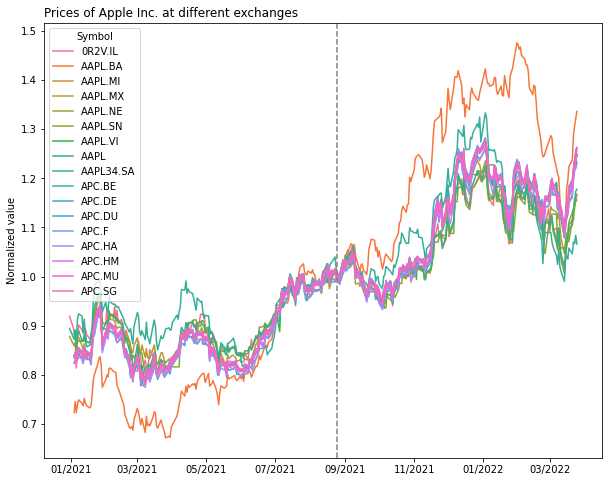

In [97]:
# https://stackoverflow.com/questions/38463369/subtitles-within-matplotlib-legend
import matplotlib.text as mtext
import matplotlib.dates as mdates

# class LegendTitle(object):
#     def __init__(self, text_props=None):
#         self.text_props = text_props or {}
#         super(LegendTitle, self).__init__()

#     def legend_artist(self, legend, orig_handle, fontsize, handlebox):
#         x0, y0 = handlebox.xdescent, handlebox.ydescent
#         title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
#         handlebox.add_artist(title)
#         return title



# Convert to datetime
df_plot['Date'] = pd.to_datetime(df_plot['Date'])

# format date column
# df_plot['Date'] = pd.to_datetime(df_plot['Date'].dt.date.astype(str))

df_plot.head()

fig = plt.figure(figsize=(10, 8))

ax = sns.lineplot(data=df_plot, x='Date', y='value', hue='Symbol')

plt.axvline(x=pd.to_datetime(min_date), color='gray', ls='--')

# Labeling and titles
plt.title("Prices of Apple Inc. at different exchanges", loc='left')

plt.xlabel('')
plt.ylabel('Normalized value')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))

# h,l = g.get_legend_handles_labels()

# g.legend(['1st Title'] + h[:6] + ['','2nd Title'] + h[6:12], 
#           ['']         + l[:6] + ['','']          + l[6:12],
#             handler_map={str: LegendTitle({'fontsize': 16})},
#           bbox_to_anchor=(1, 1)
#         )

## Volume data

In [98]:
df_plot = prices[['Symbol', 'Date', 'Volume']].melt(id_vars = ['Symbol', 'Date'])

df_plot.head() 

,Symbol,Date,variable,value
0,0R2V.IL,2020-12-31,Volume,752938.0
1,0R2V.IL,2021-01-04,Volume,868902.0
2,0R2V.IL,2021-01-05,Volume,815721.0
3,0R2V.IL,2021-01-06,Volume,1516655.0
4,0R2V.IL,2021-01-07,Volume,725402.0


<AxesSubplot:xlabel='value', ylabel='Symbol'>

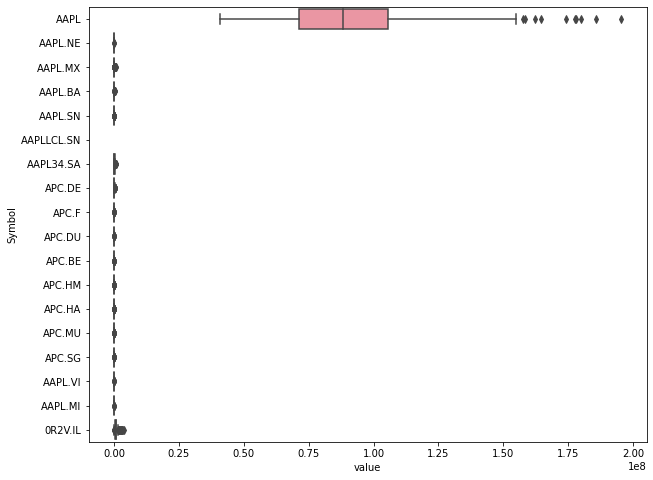

In [103]:
fig = plt.figure(figsize=(10, 8))

sns.boxplot(data=df_plot, x='value', y='Symbol', order=list(df_sym_sel.Symbol))

In [104]:
df_plot.loc[df_plot.Symbol == 'APC.F']

,Symbol,Date,variable,value
3573,APC.F,2021-01-04,Volume,29497.0
3574,APC.F,2021-01-05,Volume,11959.0
3575,APC.F,2021-01-06,Volume,12748.0
3576,APC.F,2021-01-07,Volume,18454.0
3577,APC.F,2021-01-08,Volume,25250.0
...,...,...,...,...
3883,APC.F,2022-03-21,Volume,9045.0
3884,APC.F,2022-03-22,Volume,11675.0
3885,APC.F,2022-03-23,Volume,9157.0
3886,APC.F,2022-03-24,Volume,5878.0
